In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
path = '../../../dataset_real/forward.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(55, 56, 57, 58), dtype=bool)
print("Motion data has a length of ", len(motion))

Motion data has a length of  2890


In [6]:
motion.shape

(2890, 59)

## Height-Force plots

In [7]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [8]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

In [9]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

### Step size

In [16]:
def get_step_size(dataset, footsteps, idx_coord, axes):
    # Footsteps sizes
    step_size_fr = []
    step_size_fl = []
    step_size_rr = []
    step_size_rl = []
    footstep_period = []
    
    # Compute step sizes
    idx = 1
    while idx < (len(footsteps)-1):
        time_difference = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            
        if time_difference < 0.6:
            footstep_period.append(time_difference)
                        
            # Compute rotation matrices from odometry orientation
            R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 48:52])
            R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 48:52])
            
            # Odom base vectors
            prev_base = np.array([[dataset[footsteps[idx-1], 16], dataset[footsteps[idx-1], 17], dataset[footsteps[idx-1], 18]]])
            curr_base = np.array([[dataset[footsteps[idx], 16], dataset[footsteps[idx], 17], dataset[footsteps[idx-1], 18]]])
            
            # Rotate odometry estimation
            rotated_prev_base = prev_base @ R_prev 
            rotated_curr_base = curr_base @ R_prev
            base_displacement = rotated_curr_base - rotated_prev_base
            
            if contacts[footsteps[idx], 0]:
                # FL vectors
                prev_fl = np.array([[dataset[footsteps[idx-1], 4], dataset[footsteps[idx-1], 5], dataset[footsteps[idx-1], 6]]])
                curr_fl = np.array([[dataset[footsteps[idx], 4], dataset[footsteps[idx], 5], dataset[footsteps[idx], 6]]])
                
                # RR vectors
                prev_rr = np.array([[dataset[footsteps[idx-1], 13], dataset[footsteps[idx-1], 14], dataset[footsteps[idx-1], 15]]])
                curr_rr = np.array([[dataset[footsteps[idx], 13], dataset[footsteps[idx], 14], dataset[footsteps[idx], 15]]])
                
                # Feet displacements
                fl_displacement = curr_fl - prev_fl
                rr_displacement = curr_rr - prev_rr
                
                step_size_fl.append(fl_displacement[0, axes] + base_displacement[0, axes])
                step_size_rr.append(rr_displacement[0, axes] + base_displacement[0, axes])
                
                #step_size_fl.append(fl_displacement[0, axes])
                #step_size_rr.append(rr_displacement[0, axes])
                
                #print("Curr fl: ", curr_fl, ". Prev fl: ", prev_fl, ". Displacement in y: ", fl_displacement[0, axes])
            else:
                # FR vectors
                prev_fr = np.array([[dataset[footsteps[idx-1], 7], dataset[footsteps[idx-1], 8], dataset[footsteps[idx-1], 9]]])
                curr_fr = np.array([[dataset[footsteps[idx], 7], dataset[footsteps[idx], 8], dataset[footsteps[idx], 9]]])
                
                # RL vectors
                prev_rl = np.array([[dataset[footsteps[idx-1], 10], dataset[footsteps[idx-1], 11], dataset[footsteps[idx-1], 12]]])
                curr_rl = np.array([[dataset[footsteps[idx], 10], dataset[footsteps[idx], 11], dataset[footsteps[idx], 12]]])
                
                # Feet Displacements
                fr_displacement = curr_fr - prev_fr
                rl_displacement = curr_rl - prev_rl
                            
                step_size_fr.append(fr_displacement[0, axes] + base_displacement[0, axes])
                step_size_rl.append(rl_displacement[0, axes] + base_displacement[0, axes])
                
                #step_size_fr.append(fr_displacement[0, axes])
                #step_size_rl.append(rl_displacement[0, axes])
                
        idx += 1
                    
    # Convert to numpy array
    step_size_fl_numpy = np.array(step_size_fl)
    step_size_fr_numpy = np.array(step_size_fr)
    step_size_rl_numpy = np.array(step_size_rl)
    step_size_rr_numpy = np.array(step_size_rr)
    footstep_period_numpy = np.array(footstep_period)
        
    print(min(step_size_fl_numpy), ", ", max(step_size_fl_numpy))
    print(min(step_size_fr_numpy), ", ", max(step_size_fr_numpy))
    print(min(step_size_rl_numpy), ", ", max(step_size_rl_numpy))
    print(min(step_size_rr_numpy), ", ", max(step_size_rr_numpy), "\n")
    
    # Print average step-size
    print("Avg. step size time: ", np.mean(footstep_period_numpy))
    print("Min. step size time: ", np.min(footstep_period_numpy))
    print("Max. step size time: ", np.max(footstep_period_numpy))
    print("Std. step size time: ", np.std(footstep_period_numpy), "\n")
    
    #print(footstep_period_numpy)
    print("Avg. step size for fl foot: ", np.mean(step_size_fl_numpy))
    print("Avg. step size for fr foot: ", np.mean(step_size_fr_numpy))
    print("Avg. step size for rl foot: ", np.mean(step_size_rl_numpy))
    print("Avg. step size for rr foot: ", np.mean(step_size_rr_numpy), '\n')

    # Print std. dev. step-size
    print("Std. dev. step size for fl foot: ", np.std(step_size_fl_numpy))
    print("Std. dev. step size for fr foot: ", np.std(step_size_fr_numpy))
    print("Std. dev. step size for rl foot: ", np.std(step_size_rl_numpy))
    print("Std. dev. step size for rr foot: ", np.std(step_size_rr_numpy), '\n')
    
    return step_size_fr_numpy, step_size_fl_numpy, step_size_rr_numpy, step_size_rl_numpy

def step_size_statistics(dataset, footsteps, sign, motion, coordinates, axes):
    # Step size and velocity along x axis
    for velocity in np.arange(0.1, 1.1, 0.1):
        print(f"Forward: Step size (x) {velocity * sign}")
        footsteps_velocity = footsteps[np.where((np.isclose(dataset[footsteps, motion], velocity * sign, 0.001)))[0]]
        step_size_fr_x_fwd,_,_,_ = get_step_size(dataset, footsteps_velocity, coordinates, axes)
        print("\n")

#### Forward motion

In [17]:
footsteps_fwd = get_specific_cmd(motion, 1, 0, 0)

In [18]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_fwd, 1, 1, [4, 7, 10, 13], 0)

Forward: Step size (x) 0.1
0.0429751194961705 ,  0.09938079629418972
0.030929313641955503 ,  0.09122418745288563
0.025698082190920957 ,  0.08768367319901493
0.013593715597583156 ,  0.08567343806819228 

Avg. step size time:  0.2889236088152285
Min. step size time:  0.20948338508605957
Max. step size time:  0.549161434173584
Std. step size time:  0.0336551544592865 

Avg. step size for fl foot:  0.0601913634174827
Avg. step size for fr foot:  0.06018873403230331
Avg. step size for rl foot:  0.05855254686983389
Avg. step size for rr foot:  0.05804976030170346 

Std. dev. step size for fl foot:  0.008754204090795548
Std. dev. step size for fr foot:  0.008778879335178534
Std. dev. step size for rl foot:  0.008300853643419507
Std. dev. step size for rr foot:  0.009244833939032195 



Forward: Step size (x) 0.2
0.08858373418494914 ,  0.1723067734138759
0.08340109387373573 ,  0.13899226171656132
0.0944567882320193 ,  0.17738334337210304
0.08611042080525877 ,  0.1455367113033077 

Avg. step si

ValueError: min() arg is an empty sequence

In [101]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_fwd, 1, 1, [5, 8, 11, 14], 1)

Forward: Step size (x) 0.1
-0.005070264462638557 ,  0.011495246564995424
-0.009894297368641848 ,  -0.0027013074344519345
-0.0024316202616804766 ,  0.006612834674348958
-0.006660025429396255 ,  0.0027865427377275105 

Avg. step size time:  0.6534387287886246
Min. step size time:  0.48022985458374023
Max. step size time:  0.8821938037872314
Std. step size time:  0.11094424371892601 

Avg. step size for fl foot:  0.006182231918845353
Avg. step size for fr foot:  -0.006347117656314772
Avg. step size for rl foot:  0.0017874273092625987
Avg. step size for rr foot:  -0.0018902693331694998 

Std. dev. step size for fl foot:  0.0033187432104047135
Std. dev. step size for fr foot:  0.002066922187518941
Std. dev. step size for rl foot:  0.0021821853521383464
Std. dev. step size for rr foot:  0.0025058553660363644 



Forward: Step size (x) 0.2
0.0034036711331498215 ,  0.010796573063955928
-0.009574764614985298 ,  -0.0033820123347432507
-0.004408940314245463 ,  0.002118249128884947
-0.008783848408

### Side motion (right)

In [ ]:
footsteps_side_right = get_specific_cmd(motion, 0, -1, 0)

In [ ]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_side_right, -1, 2, [4, 7, 10, 13], 0)

In [ ]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_side_right, -1, 2, [5, 8, 11, 14], 1)

### Side motions (left)

In [15]:
footsteps_side_left = get_specific_cmd(motion, 0, 1, 0)

In [16]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_side_left, 1, 2, [4, 7, 10, 13], 0)

Forward: Step size (x) 0.1


ValueError: min() arg is an empty sequence

In [17]:
# Step size and velocity along y axis
step_size_statistics(motion, footsteps_side_left, 1, 2, [5, 8, 11, 14], 1)

Forward: Step size (x) 0.1


ValueError: min() arg is an empty sequence

### Rotation (clockwise)

In [58]:
footsteps_clock = get_specific_cmd(motion, 0, 0, -1)

In [59]:
# Step size and velocity along x axis
step_size_statistics(motion, footsteps_clock, -1, 3, [4, 7, 10, 13], 0)

Forward: Step size (x) -0.1
0.0022924026563620747 ,  0.010913553707087797
-0.002399199079122033 ,  0.005538593047405643
0.0030724120885814443 ,  0.011619597549084149
-0.003874439528119944 ,  0.003449332140805894 

Avg. step size time:  0.5966205596923828
Min. step size time:  0.43451857566833496
Max. step size time:  0.8180596828460693
Std. step size time:  0.10234831947530579 

Avg. step size for fl foot:  0.007867171308536824
Avg. step size for fr foot:  0.002217705358883748
Avg. step size for rl foot:  0.007488771183020074
Avg. step size for rr foot:  0.0010889765856282156 

Std. dev. step size for fl foot:  0.002257900278242512
Std. dev. step size for fr foot:  0.0019380873670013646
Std. dev. step size for rl foot:  0.001790951774321016
Std. dev. step size for rr foot:  0.0016047679058834605 



Forward: Step size (x) -0.2
0.0059520885029885895 ,  0.013353029620265328
-0.003951282515817223 ,  0.0030061041359697727
0.007506009398126512 ,  0.012111216048875217
-0.006700174159601668 ,

In [60]:
# Step size along y axis 
step_size_statistics(motion, footsteps_clock, -1, 3, [5, 8, 11, 14], 1)

Forward: Step size (x) -0.1
-0.0014870312950792663 ,  0.007198844240623309
-0.016371215403313405 ,  -0.008163275443720253
0.002701019274379185 ,  0.011037470751345813
0.003905764884695573 ,  0.009990999304543335 

Avg. step size time:  0.5966205596923828
Min. step size time:  0.43451857566833496
Max. step size time:  0.8180596828460693
Std. step size time:  0.10234831947530579 

Avg. step size for fl foot:  0.002858736329456472
Avg. step size for fr foot:  -0.013689258924868391
Avg. step size for rl foot:  0.006867773284053546
Avg. step size for rr foot:  0.007102571019363019 

Std. dev. step size for fl foot:  0.0024708715466883594
Std. dev. step size for fr foot:  0.0020217593535743943
Std. dev. step size for rl foot:  0.0020776743259580113
Std. dev. step size for rr foot:  0.0017534282467548666 



Forward: Step size (x) -0.2
-0.0072499446587246386 ,  0.0029292193290059165
-0.022610070328092147 ,  -0.014882489108253905
0.009689902411235407 ,  0.01690256129394288
0.009654754048442238

### Rotation (counter clockwise)

In [61]:
footsteps_count = get_specific_cmd(motion, 0, 0, 1)

In [62]:
# Step size and velocity along x axis 
step_size_statistics(motion, footsteps_count, 1, 3, [4, 7, 10, 13], 0)

Forward: Step size (x) 0.1
-0.0003310592126238576 ,  0.005116248243919985
0.005083300258205942 ,  0.011333483111120507
-0.0015323177209525252 ,  0.004197672723333434
0.005272769963087842 ,  0.009389294821438965 

Avg. step size time:  0.7634296674986143
Min. step size time:  0.7122452259063721
Max. step size time:  0.8174431324005127
Std. step size time:  0.023426962215551475 

Avg. step size for fl foot:  0.002462825604261758
Avg. step size for fr foot:  0.008855918313124737
Avg. step size for rl foot:  0.0016975489707804585
Avg. step size for rr foot:  0.007107152057727933 

Std. dev. step size for fl foot:  0.0016879031761847093
Std. dev. step size for fr foot:  0.001671362258815674
Std. dev. step size for rl foot:  0.0012838712829979606
Std. dev. step size for rr foot:  0.0010344543422225099 



Forward: Step size (x) 0.2
-0.0032924693798517257 ,  0.0027607020499182122
0.009216834902976173 ,  0.016894124718487474
-0.003207580575866953 ,  0.0022667113103806424
0.006789978127421992 ,

In [63]:
# Step size along y axis 
step_size_statistics(motion, footsteps_count, 1, 3, [5, 8, 11, 14], 1)

Forward: Step size (x) 0.1
0.009514130104475771 ,  0.0169071966946599
-0.006158583795381117 ,  1.093510611019366e-05
-0.011590316822086166 ,  -0.004546692907652583
-0.009614325933846923 ,  -0.004189147967762402 

Avg. step size time:  0.7634296674986143
Min. step size time:  0.7122452259063721
Max. step size time:  0.8174431324005127
Std. step size time:  0.023426962215551475 

Avg. step size for fl foot:  0.013371312480357457
Avg. step size for fr foot:  -0.0035282679982630186
Avg. step size for rl foot:  -0.007037206002491658
Avg. step size for rr foot:  -0.006988453727548261 

Std. dev. step size for fl foot:  0.0021310735951426056
Std. dev. step size for fr foot:  0.002072113697967839
Std. dev. step size for rl foot:  0.0019608611919658694
Std. dev. step size for rr foot:  0.0014738347768251476 



Forward: Step size (x) 0.2
0.013731786339356816 ,  0.023112918770969354
-0.0014330677384449264 ,  0.004785447509325802
-0.01848943623310162 ,  -0.011342402957348424
-0.015984021867359546

### Footstep visualization

In [19]:
def yaw_from_quaternion(x, y, z, w):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)
     
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)
     
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)
     
    return roll_x, pitch_y, yaw_z # in radians

In [20]:
def visualize_static_foosteps(dataset, footsteps):
    old_xs = None
    old_ys = None
    old_zs = None
    
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        #ax.set_xlim([-0.5, 0.5])
        #ax.set_ylim([-0.3, 0.3])
        ax.set_zlim([-0.5, 0.5])

        dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)
        
        time_diff = dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0]
            
        # 3D positions        
        xs = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
        ys = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
        zz = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

        ax.scatter(xs, ys, zs, marker='o')

        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        plt.show()

        #print(xs, ys, zs, dataset[footstep, 2:5], dataset[footstep, 25:28])
        if idx > 0 and idx < len(footsteps):
            print(f'Diff: {time_diff}. Command: {dataset[footstep, 1:4]}. Coord: {[xs[0], ys[0], zs[0]]}. Step size: {[xs[0]-old_xs[0], ys[0]-old_ys[0], zs[0]-old_zs[0]]}.')
        else:
            print(f'Command: {dataset[footstep, 1:4]}. Coord: {[xs[0], ys[0], zs[0]]}.')
            
        old_xs = xs
        old_ys = ys
        old_zs = zs

In [21]:
def update_points(num, dataset, footsteps, x, y, z, points):    
    # Starting footstep index
    footstep = footsteps[num]
    
    # Round footsteps position
    dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)

    # Initial footsteps 3D positions
    new_x = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    new_y = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
    new_z = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

    # update properties
    points.set_data(new_x, new_y)
    points.set_3d_properties(new_z, 'z')

    # return modified artists
    return points

def visualize_animated_footsteps(dataset, footsteps, style: str):
    # Create figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Setting the axes properties
    ax.set_xlim3d([-0.4, 0.4])
    ax.set_xlabel('X')

    ax.set_ylim3d([-0.2, 0.2])
    ax.set_ylabel('Y')

    ax.set_zlim3d([-0.5, 0.5])
    ax.set_zlabel('Z')

    # Starting footstep index
    footstep = footsteps[0]

    # Round footsteps position
    dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)

    # Initial footsteps 3D positions
    x = np.array([dataset[footstep, 8], dataset[footstep, 11], dataset[footstep, 14], dataset[footstep, 17]])
    y = np.array([dataset[footstep, 9], dataset[footstep, 12], dataset[footstep, 15], dataset[footstep, 18]])
    z = np.array([dataset[footstep, 10], dataset[footstep, 13], dataset[footstep, 16], dataset[footstep, 19]])

    txt = fig.suptitle('')
    points, = ax.plot(x, y, z, style)
    
    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, update_points, frames=len(footsteps), fargs=(dataset, footsteps, x, y, z, points))
    
    return anim   

In [22]:
def visualize_absolute_foostep_sizes(dataset, footsteps):
    prev_yaw = 0
    
    # Visualize footsteps
    for idx, footstep in enumerate(footsteps):
        dataset[footstep, 8:20] = np.round(dataset[footstep, 8:20], 3)
        
        if idx < (len(footsteps) - 1):
            print("Command: ", dataset[footstep, 1:4])
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx+1], 0])
            
            if time_difference < 1:
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
                axes[0].set_xlabel('X Label')
                axes[0].set_ylabel('Y Label')
                axes[1].set_xlabel('X Label')
                axes[1].set_ylabel('Y Label')
                    
                # Get euler angles from odom to base rotation
                _, _, curh_yaw = yaw_from_quaternion(dataset[footstep, 47], dataset[footstep, 48], dataset[footstep, 49], dataset[footstep, 50])
                _, _, curr_yaw = yaw_from_quaternion(dataset[footsteps[idx+1], 47], dataset[footsteps[idx+1], 48], dataset[footsteps[idx+1], 49], dataset[footsteps[idx+1], 50])

                # Compute rotation matrix
                c_curh, s_curh = np.cos(curh_yaw), np.sin(curh_yaw)
                c_curr, s_curr = np.cos(curr_yaw), np.sin(curr_yaw)
                R_curh = np.array(((c_curh, -s_curh), (s_curh, c_curh)))
                R_curr = np.array(((c_curr, -s_curr), (s_curr, c_curr)))
                
                # Odom base vectors
                curh_base = np.array([[dataset[footstep, 44], dataset[footstep, 45]]])
                curr_base = np.array([[dataset[footsteps[idx+1], 44], dataset[footsteps[idx+1], 45]]])
                
                # Local base vectors
                rotated_curh_base = R_curh.T @ curh_base.T
                rotated_prev_base = R_curh.T @ curr_base.T
                rotated_prev_base_curr = R_curr.T @ curr_base.T
                base_displacement = rotated_prev_base - rotated_curh_base
                
                #print("Footstep timestamp: ", dataset[footstep, 0])
                print(f'\nFL moving: {contacts[idx, 0]}. FR moving: {contacts[idx, 1]}')
                print(f'RL moving: {contacts[idx, 2]}. RR moving: {contacts[idx, 3]}')
                
                #print(f'Curh base (not transformed): {dataset[footstep, 31:33]}. Next base (not transformed): {dataset[footsteps[idx+1], 31:33]}.')
                #print(f'Curh base transformed (x): {rotated_curh_base.tolist()}.\nNext base transformed (y): {rotated_prev_base.tolist()}.\nNext base transformed2 (y): {rotated_prev_base_curr.tolist()}\n')
                print(prev_yaw, curh_yaw)
                print(f'Base displacement: {base_displacement.tolist()}. Rotation displacement: {(curh_yaw - prev_yaw) * 180 / np.pi}.\n')
                
                print("CoM displacement: ")
                print(f'lf (x): {dataset[footsteps[idx], 8]}, {dataset[footsteps[idx+1], 8]}, lf (y): {dataset[footsteps[idx], 9]}, {dataset[footsteps[idx+1], 9]}.')
                print(f'lf displacement: {(dataset[footsteps[idx+1], 8] - dataset[footsteps[idx], 8]).tolist()}, {(dataset[footsteps[idx+1], 9] - dataset[footsteps[idx], 9]).tolist()}.\n')
                
                print(f'lh (x): {dataset[footsteps[idx], 11]}, {dataset[footsteps[idx+1], 11]}, lh (y): {dataset[footsteps[idx], 12]}, {dataset[footsteps[idx+1], 12]}.')
                print(f'lh displacement: {(dataset[footsteps[idx+1], 11] - dataset[footsteps[idx], 11]).tolist()}, {(dataset[footsteps[idx+1], 12] - dataset[footsteps[idx], 12]).tolist()}.\n')
                
                print(f'rf (x): {dataset[footsteps[idx], 14]}, {dataset[footsteps[idx+1], 14]}, rf (y): {dataset[footsteps[idx], 15]}, {dataset[footsteps[idx+1], 15]}.')
                print(f'rf displacement: {(dataset[footsteps[idx+1], 14] - dataset[footsteps[idx], 14]).tolist()}, {(dataset[footsteps[idx+1], 15] - dataset[footsteps[idx], 15]).tolist()}.\n')
                
                print(f'rh (x): {dataset[footsteps[idx], 17]}, {dataset[footsteps[idx+1], 17]}, rh (y): {dataset[footsteps[idx], 18]}, {dataset[footsteps[idx+1], 18]}.')
                print(f'rh displacement: {(dataset[footsteps[idx+1], 17] - dataset[footsteps[idx], 17]).tolist()}, {(dataset[footsteps[idx+1], 18] - dataset[footsteps[idx], 18]).tolist()}.\n')
        
                # Feet displacements
                lf_x_displacement = dataset[footsteps[idx+1], 8] - dataset[footsteps[idx], 8]
                lf_y_displacement = dataset[footsteps[idx+1], 9] - dataset[footsteps[idx], 9]
                lh_x_displacement = dataset[footsteps[idx+1], 11] - dataset[footsteps[idx], 11]
                lh_y_displacement = dataset[footsteps[idx+1], 12] - dataset[footsteps[idx], 12]
                rf_x_displacement = dataset[footsteps[idx+1], 14] - dataset[footsteps[idx], 14]
                rf_y_displacement = dataset[footsteps[idx+1], 15] - dataset[footsteps[idx], 15]
                rh_x_displacement = dataset[footsteps[idx+1], 17] - dataset[footsteps[idx], 17]
                rh_y_displacement = dataset[footsteps[idx+1], 18] - dataset[footsteps[idx], 18]
                
                # Support foot base displacement
                support_base_displacement = [0, 0]
                if contacts[idx, 1]:
                    support_base_displacement[0] = -lf_x_displacement
                    support_base_displacement[1] = -lf_y_displacement
                else:
                    support_base_displacement[0] = -rf_x_displacement
                    support_base_displacement[1] = -rf_y_displacement
                
                prev_yaw = curh_yaw
                    
                print(f'\nBase displacement (CoM): {support_base_displacement}.\n')
                    
                x_0 = np.array([dataset[footstep, 8], 
                                dataset[footstep, 11],
                                dataset[footstep, 14], 
                                dataset[footstep, 17]])
                y_0 = np.array([dataset[footstep, 9], 
                                dataset[footstep, 12],
                                dataset[footstep, 15], 
                                dataset[footstep, 18]])
                
                """
                x_1 = np.array([dataset[footsteps[idx+1], 7], 
                                dataset[footsteps[idx+1], 10],
                                dataset[footsteps[idx+1], 13], 
                                dataset[footsteps[idx+1], 16]])
                y_1 = np.array([dataset[footsteps[idx+1], 8], 
                                dataset[footsteps[idx+1], 11],
                                dataset[footsteps[idx+1], 14], 
                                dataset[footsteps[idx+1], 17]])
                """
                
                x_1 = np.array([dataset[footstep, 8] + lf_x_displacement, 
                                dataset[footstep, 11] + rf_x_displacement,
                                dataset[footstep, 14] + lh_x_displacement, 
                                dataset[footstep, 17] + rh_x_displacement])
                y_1 = np.array([dataset[footstep, 9] + lf_y_displacement, 
                                dataset[footstep, 12] + rf_y_displacement,
                                dataset[footstep, 15] + lh_y_displacement, 
                                dataset[footstep, 18] + rh_y_displacement])
                
                #axes[0].scatter(x_0, y_0, c= 'b',marker='o')
                axes[0].scatter(x_0, y_0, c= 'm',marker='o')
                axes[0].scatter(0, 0, c= 'g', marker='^')
                axes[0].scatter(base_displacement[0], base_displacement[1], c= 'y', marker='^')
                axes[0].scatter(support_base_displacement[0], support_base_displacement[1], c= 'r', marker='^')
                
                axes[1].scatter(x_1, y_1, c= 'r', marker='o')
                axes[1].scatter(x_1, y_1, c= 'c', marker='o')
                
                plt.show()
                
#visualize_absolute_foostep_sizes(motion, footsteps_fwd)                  

### Forward motion

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_fwd, "bo")
HTML(anim.to_html5_video())

### Side motion (right)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_side_right, "bo")
HTML(anim.to_html5_video())

### Side motion (left)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_side_left, "bo")
HTML(anim.to_html5_video())

### Rotation (clockwise)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_clock, "bo")
HTML(anim.to_html5_video())

### Rotation (counter clockwise)

In [ ]:
anim = visualize_animated_footsteps(motion, footsteps_count, "bo")
HTML(anim.to_html5_video())

# Dataset Preparation

In [23]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [24]:
def get_continuous_footstep_dataset(dataset, footsteps, debug=False):
    # Footsteps sizes
    inputs = []
    labels = []
    
    idx = 1
    while idx < (len(footsteps) - 1):
        time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
                                        
        if time_difference < 0.6:
            lf_rh_moving = contacts[footsteps[idx], 0]
            rf_lh_moving = contacts[footsteps[idx], 1]
            
            if lf_rh_moving == rf_lh_moving:
                idx += 1
                continue
            
            # Compute rotation matrices from odometry orientation
            R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 48:52])
            R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 48:52])
            
            # Odom base vectors
            prev_base = np.array([[dataset[footsteps[idx-1], 16], dataset[footsteps[idx-1], 17], dataset[footsteps[idx-1], 18]]])
            curr_base = np.array([[dataset[footsteps[idx], 16], dataset[footsteps[idx], 17], dataset[footsteps[idx], 18]]])
            base_displacement = curr_base @ R_prev - prev_base @ R_prev
            
            inputs.append(dataset[footsteps[idx-1], 1:16].tolist() +
                          dataset[footsteps[idx], 1:4].tolist() +
                          [lf_rh_moving, rf_lh_moving])
            
            if lf_rh_moving:
                # FL vectors
                prev_fl = np.array([[dataset[footsteps[idx-1], 4], dataset[footsteps[idx-1], 5], 0]])
                curr_fl = np.array([[dataset[footsteps[idx], 4], dataset[footsteps[idx], 5], 0]])
                
                # RR vectors
                prev_rr = np.array([[dataset[footsteps[idx-1], 13], dataset[footsteps[idx-1], 14], 0]])
                curr_rr = np.array([[dataset[footsteps[idx], 13], dataset[footsteps[idx], 14], 0]])
                
                # Feet displacements
                fl_displacement = curr_fl - prev_fl + base_displacement
                rr_displacement = curr_rr - prev_rr + base_displacement
                
                labels.append([fl_displacement[0,0], fl_displacement[0,1], rr_displacement[0,0], rr_displacement[0,1]])
            else:
                # FR vectors
                prev_fr = np.array([[dataset[footsteps[idx-1], 7], dataset[footsteps[idx-1], 8], 0]])
                curr_fr = np.array([[dataset[footsteps[idx], 7], dataset[footsteps[idx], 8], 0]])
                
                # RL vectors
                prev_rl = np.array([[dataset[footsteps[idx-1], 10], dataset[footsteps[idx-1], 11], 0]])
                curr_rl = np.array([[dataset[footsteps[idx], 10], dataset[footsteps[idx], 11], 0]])
                
                # Feet displacements
                fr_displacement = curr_fr - prev_fr + base_displacement
                rl_displacement = curr_rl - prev_rl + base_displacement
                
                labels.append([fr_displacement[0,0], fr_displacement[0,1], rl_displacement[0,0], rl_displacement[0,1]])
            
        idx += 1
                
    # Convert to numpy array
    inputs_numpy = np.array(inputs)
    labels_numpy = np.array(labels)
    
    return inputs_numpy, labels_numpy

X_relative_footsteps_fwd, Y_relative_footsteps_fwd = get_continuous_footstep_dataset(motion, footsteps_fwd)
#X_relative_footsteps_clock, Y_relative_footsteps_clock = get_continuous_footstep_dataset(motion, footsteps_clock)
#X_relative_footsteps_count, Y_relative_footsteps_count = get_continuous_footstep_dataset(motion, footsteps_count)
#X_relative_footsteps_left, Y_relative_footsteps_left = get_continuous_footstep_dataset(motion, footsteps_side_left)
#X_relative_footsteps_right, Y_relative_footsteps_right = get_continuous_footstep_dataset(motion, footsteps_side_right)

# Stack datasets
#X_footsteps_continuous_absolute = np.concatenate((X_relative_footsteps_fwd, X_relative_footsteps_clock, X_relative_footsteps_count))
#Y_footsteps_continuous_absolute = np.concatenate((Y_relative_footsteps_fwd, Y_relative_footsteps_clock, Y_relative_footsteps_count))

X_footsteps_continuous_absolute = X_relative_footsteps_fwd
Y_footsteps_continuous_absolute = Y_relative_footsteps_fwd

# Log
print(X_footsteps_continuous_absolute.shape)
print(Y_footsteps_continuous_absolute.shape)

(2145, 20)
(2145, 4)


In [25]:
%store X_footsteps_continuous_absolute
%store Y_footsteps_continuous_absolute

Stored 'X_footsteps_continuous_absolute' (ndarray)
Stored 'Y_footsteps_continuous_absolute' (ndarray)


/home/ilyass/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ilyass/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


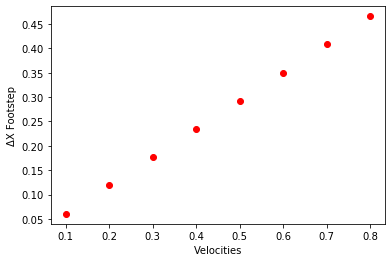

In [26]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_relative_footsteps_fwd[np.where(np.isclose(X_relative_footsteps_fwd[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394X Footstep')
plt.show()

/home/ilyass/.local/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ilyass/.local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ilyass/.local/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


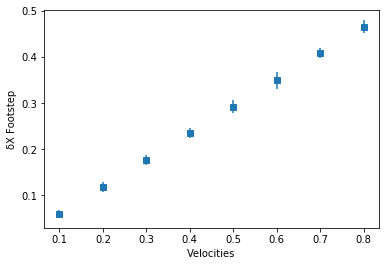

In [27]:
x = np.array(np.arange(0.1, 1.1, 0.1))
y = np.array([np.mean(Y_relative_footsteps_fwd[np.where(np.isclose(X_relative_footsteps_fwd[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_relative_footsteps_fwd[np.where(np.isclose(X_relative_footsteps_fwd[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4X Footstep')
plt.show()

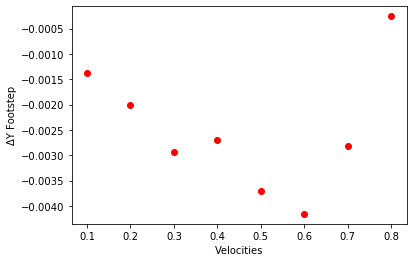

In [28]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_relative_footsteps_fwd[np.where(np.isclose(X_relative_footsteps_fwd[:, 0], velocity))[0], 1]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y Footstep')
plt.show()

In [29]:
x = np.arange(0.1, 1.1, 0.1)
y = np.array([np.mean(Y_relative_footsteps_count[np.where(np.isclose(X_relative_footsteps_count[:, 2], velocity))[0], 1]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_relative_footsteps_count[np.where(np.isclose(X_relative_footsteps_count[:, 2], velocity))[0], 1]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y Footstep')
plt.show()

NameError: name 'Y_relative_footsteps_count' is not defined